# Project 2 - Spectral Clustering

### Points

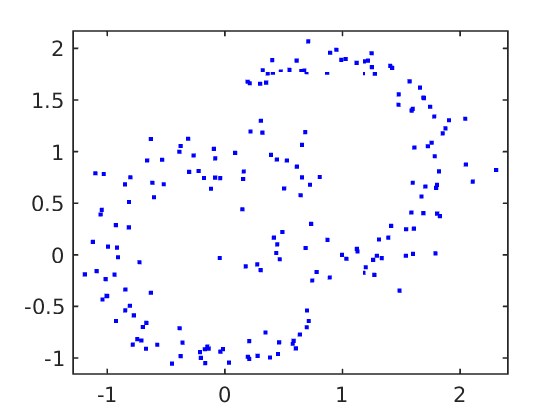

N =

   192


In [21]:
load('Points.mat')
N=size(points,1)
plot(points(:,1),points(:,2),'b.');
xlim([min(points(:,1))-0.1,max(points(:,1))+0.1]);
ylim([min(points(:,2))-0.1,max(points(:,2))+0.1]);

### Graph and Weight Matrices


In [ ]:
function [G, W] = constructGraph(points,K,sigma)
    N=size(points,1);
    G = zeros(N);
    W = zeros(N);
    for i=1:N
        dists = zeros(1,N);
        for j=1:N
            dists(j) = norm(points(i,:)-points(j,:));
        end
        [B,I] = sort(dists);
        for k=2:K+1
            G(i,I(k))=1;
            G(I(k),i)=1;
            W(i,I(k))=exp(-0.5*(B(k)/sigma)^2);
            W(I(k),i)=W(i,I(k));
        end
    end
end

function plotGraph(points,G)
    plot(points(:,1),points(:,2),'b.');
    hold on;
    for i=1:N
        for j=i:N
            if G(i,j) == 1
                x = [points(i,1),points(j,1)]';
                y = [points(i,2),points(j,2)]';
                plot(x,y,'b');
            end
        end
    end
end


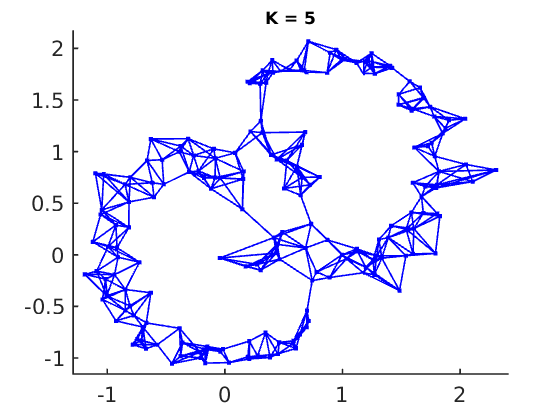

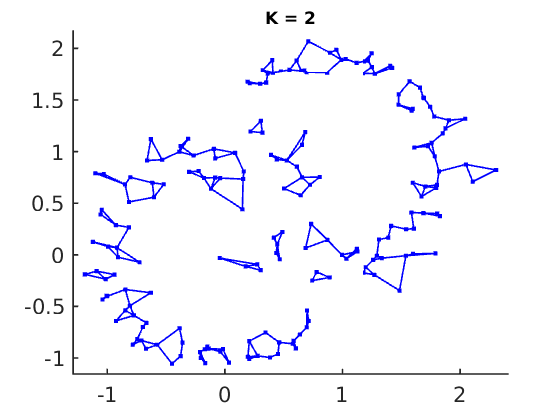

In [22]:
K=2;
sigma = 0.3;
[G, W] = constructGraph(points,K,sigma);
figure;
plotGraph(points,G);
xlim([min(points(:,1))-0.1,max(points(:,1))+0.1]);
ylim([min(points(:,2))-0.1,max(points(:,2))+0.1]);
title(sprintf('K = %d',K),'FontSize', 8);

K=5;
figure;
[G, W] = constructGraph(points,K,sigma);
plotGraph(points,G);
xlim([min(points(:,1))-0.1,max(points(:,1))+0.1]);
ylim([min(points(:,2))-0.1,max(points(:,2))+0.1]);
title(sprintf('K = %d',K),'FontSize', 8);

### The Laplacian matrix
$$ L = I-WD^{-1} $$

In [50]:
% Calculate the Laplacian matrix
d = sum(G,2) ;
Dinv = diag(1./d);
T = W*Dinv;
T = T./repmat(sum(T),N,1);
L = eye(N)-T;

### The second smallest eigenvalue and the corresponding vector

Let the eigenvalues of the Laplacian matrix $L$ be $\lambda_1 \leq \lambda_2 \leq \ldots \leq \lambda_N$. We know $\lambda_1$ is $0$ and the corresponding eigenvector is $[1, 1, \ldots, 1]^\intercal$, because the sum of entries in each row is $0$. We can use Householder Deflation to obtain the matrix $A$ whose eigenvalues are $\lambda_2 \leq \lambda_3 \leq \ldots \leq \lambda_N$.
\begin{align*}
  H\mathbf{1} &=\alpha e_1 \\
  S = HLH^\intercal &= 
  \begin{bmatrix} 
    \lambda_1 & x^\intercal \\
    0         & A
  \end{bmatrix} \\
\end{align*}
We can calculate $\lambda_2$ and the corresponding eigenvector by inverse iteration.

Let $v$ be the eigenvector of $A$ that corresponds to $\lambda_2$,

\begin{align*}
  S\begin{bmatrix}
    a \\
    v \\
  \end{bmatrix} &= 
  \begin{bmatrix} 
    \lambda_1 & x^\intercal \\
    0         & A
  \end{bmatrix}
  \begin{bmatrix}
    a \\
    v \\
  \end{bmatrix} = 
  \begin{bmatrix}
    \lambda_1a + x^\intercal v \\
    Av \\
  \end{bmatrix} = 
  \begin{bmatrix}
    x^\intercal v \\
    Av \\
  \end{bmatrix} = 
  \begin{bmatrix}
    \lambda_2a \\
    \lambda_2v \\
  \end{bmatrix}\\
  \implies a = \dfrac{x^\intercal v}{\lambda_2}
\end{align*}
And Let $u$ be the eigenvector of $L$ that corresponds to $\lambda_2$,
\begin{align*}
  u=H^\intercal\begin{bmatrix}
    a \\
    v \\
  \end{bmatrix}
\end{align*}

In [66]:
% Calculate A
e = zeros(size(L,1),1);
e(1) = 1;
x = ones(size(L,1),1);
x = x/norm(x);
v = sign(x(1))*norm(x)*e + x;
v = v/norm(v);
H=eye(length(v))-2*v*v';
S=H*L*H';
A = S(2:end,2:end);


% Use inverse iteration method to find the smallest eigenvalue of A
V = ones(N-1,1);
V = V/norm(V);
Vprev = V;
lambda = 1;

epsilon = 1e-10;
delta = 1; 
[Q, R] = qr(A);
opts.UT = true;
while epsilon < delta
    V = linsolve(R,Q'*Vprev,opts);
    lambda = transpose(V)*A*V;
    V = V/norm(V);
    delta = norm(Vprev-V);
    Vprev = V;
end
%Vprev is the eigenvector of A that corresponds to lambda_2
V(1) = S(1,2:end)*Vprev*lambda;
V(2:N) = Vprev;
%V is the eigenvector of S that corresponds to lambda_2
V = H'*V;
%Now, V is the eigenvector of L that corresponds to lambda_2

### The histogram of the Fiedler vector

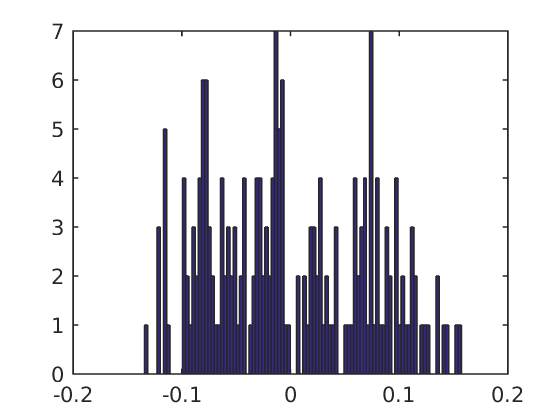

In [67]:
hist(V,100);

Let's choose $\tau = 0$

### Clustering

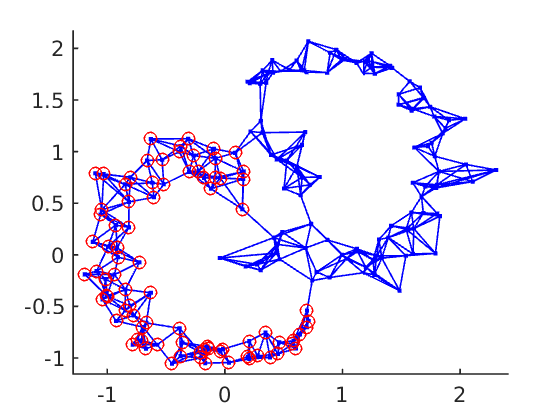

In [68]:
tau = 0;
figure;
plotGraph(points,G);
hold on;
labels = V > tau;
plot(points(labels,1),points(labels,2),'ro');
hold off;
xlim([min(points(:,1))-0.1,max(points(:,1))+0.1]);
ylim([min(points(:,2))-0.1,max(points(:,2))+0.1]);

### The program

In [ ]:
function [Labels, WeightMatrix] = project3(points, k, sigma, tau)

N=size(points,1);
[G, W] = constructGraph(points,k,sigma);
WeightMatrix = W;

% Calculate the Laplacian matrix
d = sum(G,2) ;
Dinv = diag(1./d);
T = W*Dinv;
T = T./repmat(sum(T),N,1);
L = eye(N)-T;

% Calculate A
e = zeros(size(L,1),1);
e(1) = 1;
x = ones(size(L,1),1);
x = x/norm(x);
v = sign(x(1))*norm(x)*e + x;
v = v/norm(v);
H=eye(length(v))-2*v*v';
S=H*L*H';
A = S(2:end,2:end);

% Use inverse iteration method to find the smallest eigenvalue of A
V = ones(N-1,1);
V = V/norm(V);
Vprev = V;
lambda = 1;

epsilon = 1e-10;
delta = 1; 
[Q, R] = qr(A);
opts.UT = true;
while epsilon < delta
    V = linsolve(R,Q'*Vprev,opts);
    lambda = transpose(V)*A*V;
    V = V/norm(V);
    delta = norm(Vprev-V);
    Vprev = V;
end
%Vprev is the eigenvector of A that corresponds to lambda_2
V(1) = S(1,2:end)*Vprev*lambda;
V(2:N) = Vprev;
%V is the eigenvector of G that corresponds to lambda_2
V = H'*V;
%Now, V is the eigenvector of L that corresponds to lambda_2

% Calculate Labels
Labels = V > tau;

end